In [25]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data
import torch.optim as optim
import torchvision     
import torchvision.transforms as transforms
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
from graphviz import Digraph
from scipy import signal
import os
import sys
import time
import math
import numpy as np
import datetime as dt
import tqdm
import argparse
import glob
import matplotlib.pyplot as plt
import tarfile
import warnings 
warnings.filterwarnings("ignore") 

data_file = 'input'
load_model_dir = 'checkpoint/'
if os.path.basename(os.path.dirname(os.path.realpath('__file__'))) == 'working':
    load_model_dir = '../input/cifar10-moblienet-checkpoint-97-0905-v11/'
    t = tarfile.open('../input/cifar10-python/cifar-10-python.tar.gz')
    t.extractall(path = 'input')
print(os.listdir('input'))

['.ipynb_checkpoints', 'cifar-10-batches-py', 'cifar-10-python.tar.gz']


In [26]:
# 加载数据

# trainset = torchvision.datasets.CIFAR10(root='../working/input', train=True)
# rgb_mean = np.mean(trainset.train_data, axis=(0, 1, 2))/255
# rgb_std = np.std(trainset.train_data, axis=(0, 1, 2))/255
# 参考： https://github.com/kuangliu/pytorch-cifar/issues/8
#在另一种处理下得到的结果为：rgb_mean： ((0.4914, 0.4822, 0.4465),rgb_std： (0.2023, 0.1994, 0.2010)) 
rgb_mean = (0.4914, 0.4822, 0.4465)
rgb_std = (0.2470, 0.2435, 0.2616)

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(p = 0.2),
    transforms.ToTensor(),
    transforms.Normalize(rgb_mean, rgb_std),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(rgb_mean,rgb_std),
])
# '../working/cifar10-python'
trainset = torchvision.datasets.CIFAR10(root='input', 
                                        train=True, download=False, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=200, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='input', 
                                       train=False, download=False, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print('数据加载完毕..')

数据加载完毕..


# 建立模型

In [27]:
def print_gpu_information():
    cur_device = torch.cuda.current_device()
    device_name = torch.cuda.get_device_name(device = cur_device)
    device_cap = torch.cuda.get_device_capability(device = cur_device)
    max_memory = torch.cuda.max_memory_allocated(device = cur_device)   
    print('GPU 型号:{}     算力:{}.{}     可用内存:{} B\t'.format(
        device_name,device_cap[0],device_cap[1],max_memory))  
class Block(nn.Module):
        
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride,
                               padding=1, groups=in_planes, bias=False)
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        return out

class MobileNet(nn.Module):  # 继承 torch 的 Module
    cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), 1024]

    def __init__(self, num_classes=10):
        super(MobileNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32)
        self.linear = nn.Linear(1024, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for x in self.cfg:
            if isinstance(x, int) :
                out_planes = x
                stride = 1    
            else :
                out_planes = x[0]
                stride =  x[1]
            layers.append(Block(in_planes, out_planes, stride))
            in_planes = out_planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.avg_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out
    
mobilenet = MobileNet(num_classes=10)
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
    mobilenet.cuda()
#     print_gpu_information()
print('模型搭建完毕..')
mobilenet

模型搭建完毕..


MobileNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Block(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Block(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=64, bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2):

# 模型训练

In [28]:
# 训练函数
def train_net():
    mobilenet.train()
    train_loss = 0
    n_correct = 0
    n_total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
#         进行训练
        optimizer.zero_grad()
        outputs = mobilenet(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
#         记录过程
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        n_correct += predicted.eq(targets).sum().item()
        n_total += targets.shape[0]
    return train_loss/(batch_idx+1),n_correct/n_total
# 获取准确率
def get_loss_acc(is_test_dataset = True):
    mobilenet.eval()
    dataloader = testloader if is_test_dataset else trainloader
    n_correct = 0
    n_total = 0
    test_loss = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(dataloader):
            inputs, targets = inputs.to(device), targets.to(device)
#         记录过程
            outputs = mobilenet(inputs)
            test_loss += criterion(outputs, targets).item()
            _, predicted = outputs.max(1)
            n_correct += predicted.eq(targets).sum().item()
            n_total += targets.shape[0]
    return test_loss/(batch_idx+1),n_correct/n_total

def save_modle(model_path,state_dict,acc,epoch,hist):
        state = {
            'net': mobilenet.state_dict(),
            'acc': acc,
            'epoch': epoch,
            'hist': hist
        }
        torch.save(state, model_path)

In [29]:
# 加载模型
loadModel = True 
save_model_dir = 'checkpoint/'
best_acc = 0
start_epoch = 0
lr = 0.1
hist = []
if not os.path.isdir(save_model_dir):
    os.mkdir(save_model_dir)
load_path = glob.glob(load_model_dir + 'checkpoint-*-0.9*')
if loadModel:
    if len(load_path)>0:
        lr = 0.0005
        load_path = load_path[-1]
        checkpoint = torch.load(load_path)
        start_epoch = checkpoint['epoch']
        best_acc = checkpoint['acc']
        hist = checkpoint['hist']
        mobilenet.load_state_dict(checkpoint['net'])
        print("=> loaded checkpoint '{}' ".format(load_path))
    else:
        print('file not found')
        

=> loaded checkpoint 'checkpoint\checkpoint-97-0.905_v11.best.h5' 


In [31]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(mobilenet.parameters(), lr=lr, momentum=0.9, weight_decay=2.5e-3)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 0.92 ** epoch)

EPOCH = 0
start = dt.datetime.now()
for epochi in range(start_epoch,start_epoch + EPOCH):
    scheduler.step()
    cur_lr = [i['lr'] for i in optimizer.param_groups][0]
    print('(%.2fs)\n\nEpoch: %d/%d | cur_lr:%.4f ' % (
       (dt.datetime.now()-start).seconds, epochi+1,EPOCH+start_epoch,cur_lr))
    start = dt.datetime.now()
    
#     进行训练
    test_loss , test_acc = get_loss_acc()
    train_loss , train_acc = train_net()
    hist.append([train_loss , train_acc,test_loss , test_acc])
    print( 'train Loss: %.3f | Acc: %.3f%% \ntest Loss: %.3f | Acc: %.3f%% ' % (
        train_loss, train_acc*100,test_loss, test_acc*100))
    
#     保存模型
    if test_acc > best_acc:
        print( 'acc: %.3f -->  %.3f ' % (best_acc,test_acc))
        save_model_path = save_model_dir + '/checkpoint-{:02d}-{:.3f}.h5'.format(epochi,test_acc)
        print("saving '{}'..." .format(save_model_path))
        save_modle(save_model_path,mobilenet.state_dict(),test_acc,epochi,hist)
        best_acc = test_acc

# 画出学习曲线


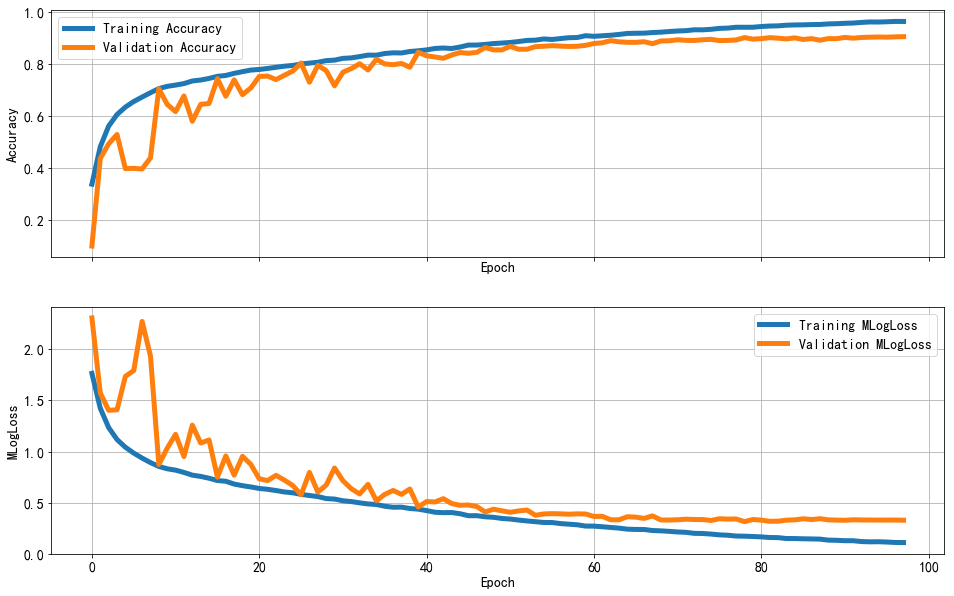

In [32]:
if len(hist)>1:    
    import matplotlib.pyplot as plt
    plt.rcParams['figure.figsize'] = [16, 10]
    plt.rcParams['font.size'] = 14
    hist = np.array(hist)
    fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(16, 10))
    axs[0].plot(hist[:,1], lw=5, label='Training Accuracy')
    axs[0].plot(hist[:,3], lw=5, label='Validation Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].grid()
    axs[0].legend(loc=0)
    axs[1].plot(hist[:,0], lw=5, label='Training MLogLoss')
    axs[1].plot(hist[:,2], lw=5, label='Validation MLogLoss')
    axs[1].set_ylabel('MLogLoss')
    axs[1].set_xlabel('Epoch')
    axs[1].grid()
    axs[1].legend(loc=0)
    fig.savefig('hist.png', dpi=300)
    plt.show();

# 卷积核的可视化

In [33]:
# 获取模型参数
mobile_weight = mobilenet.state_dict()
mobile_weight.keys()

odict_keys(['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'layers.0.conv1.weight', 'layers.0.bn1.weight', 'layers.0.bn1.bias', 'layers.0.bn1.running_mean', 'layers.0.bn1.running_var', 'layers.0.bn1.num_batches_tracked', 'layers.0.conv2.weight', 'layers.0.bn2.weight', 'layers.0.bn2.bias', 'layers.0.bn2.running_mean', 'layers.0.bn2.running_var', 'layers.0.bn2.num_batches_tracked', 'layers.1.conv1.weight', 'layers.1.bn1.weight', 'layers.1.bn1.bias', 'layers.1.bn1.running_mean', 'layers.1.bn1.running_var', 'layers.1.bn1.num_batches_tracked', 'layers.1.conv2.weight', 'layers.1.bn2.weight', 'layers.1.bn2.bias', 'layers.1.bn2.running_mean', 'layers.1.bn2.running_var', 'layers.1.bn2.num_batches_tracked', 'layers.2.conv1.weight', 'layers.2.bn1.weight', 'layers.2.bn1.bias', 'layers.2.bn1.running_mean', 'layers.2.bn1.running_var', 'layers.2.bn1.num_batches_tracked', 'layers.2.conv2.weight', 'layers.2.bn2.weight', 'layers.2.bn2.bias', '

In [34]:
# 实现卷积
def cov(lay_w,input_img):
    input_channel = lay_w.shape[0]
    output_channel = lay_w.shape[1]
    cov_result = np.zeros((32,32,input_channel,output_channel))
    # 实现卷积
    for i in range(input_channel):
        for j in range(output_channel):
            cov_result[:,:,i,j]=signal.convolve2d(input_img[:,:,j],lay_w[i,j,:,:],
                                                  boundary='symm',mode='same')
    cov_result = cov_result.sum(axis=3)
    cov_result.shape
    return cov_result

In [35]:
# 绘图
def plot_img_by_channel(input_img,axs = None,title = None):
    cols = 16
    n_channel = input_img.shape[-1]
    for i in range(n_channel):
        ax_x = i//cols
        ax_y = i%cols
        if n_channel<cols:
            ax = axs[ax_y]
        else:
            ax = axs[ax_x,ax_y]
        ax.imshow(input_img[:,:,i])
        if not title == None:
            ax.set_title(title[i])
    
    for i in range(axs.shape[0]):
        if len(axs.shape)==1: 
            axs[i].axis('off')
        else:
            for j in range(axs.shape[1]):
                axs[i,j].axis('off')

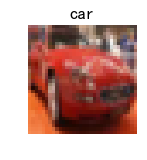

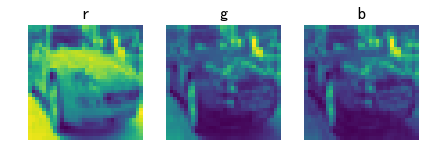

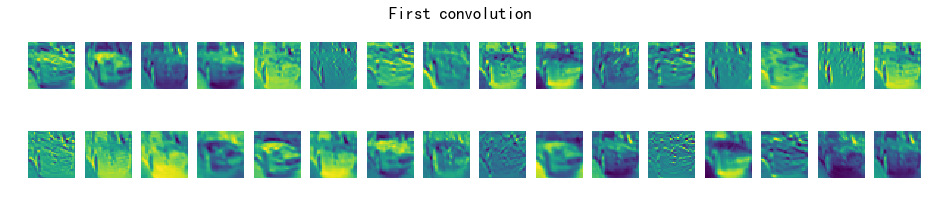

In [36]:
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# 取一张用于演示的图片
n = 5
input_img =  trainset.train_data[n]
img_label =  trainset.train_labels[n]

# 获取卷积核权重并进行卷积
mobile_weight = mobilenet.state_dict()
lay_w1 = mobile_weight['conv1.weight'].cpu().numpy()
cov_result1 = cov(lay_w1,input_img)

# 画出最终结果
fig,ax = plt.subplots( figsize=(2,2))
ax.imshow(input_img)
ax.axis('off')
ax.set_title(classes[img_label])
plt.show()
# r，g，b
fig,axs = plt.subplots(1,3,figsize=(7,3))
plot_img_by_channel(input_img,axs = axs,title = ['r','g','b'])
# 第一次卷积
fig,axs = plt.subplots(2, 16,figsize=(16,3))
plot_img_by_channel(cov_result1,axs = axs)
plt.suptitle('First convolution')

plt.show()


#  画出网络结构


In [37]:
#  [make_dot] 源码见：https://github.com/szagoruyko/pytorchviz/blob/master/torchviz/dot.py
def make_dot(var, params=None):
    """ Produces Graphviz representation of PyTorch autograd graph
    Blue nodes are the Variables that require grad, orange are Tensors
    saved for backward in torch.autograd.Function
    Args:
        var: output Variable
        params: dict of (name, Variable) to add names to node that
            require grad (TODO: make optional)
    """
    if params is not None:
        assert isinstance(params.values()[0], Variable)
        param_map = {id(v): k for k, v in params.items()}

    node_attr = dict(style='filled',
                 shape='plaintext',
                 align='left',
                 fontsize='12',
                 ranksep='0.1',
                 height='0.2')
    

    dot = Digraph(node_attr=node_attr, graph_attr=dict(size="12,12"),format='png')
    seen = set()

    def size_to_str(size):
        return '('+(', ').join(['%d' % v for v in size])+')'
    def add_nodes(var):
        if var not in seen:
            if torch.is_tensor(var):
                dot.node(str(id(var)), size_to_str(var.size()), fillcolor='orange')
            elif hasattr(var, 'variable'):
                u = var.variable
                name = param_map[id(u)] if params is not None else ''
                node_name = '%s\n %s' % (name, size_to_str(u.size()))
                dot.node(str(id(var)), node_name, fillcolor='lightblue')
            else:
                dot.node(str(id(var)), str(type(var).__name__))
            seen.add(var)
            if hasattr(var, 'next_functions'):
                for u in var.next_functions:
                    if u[0] is not None:
                        dot.edge(str(id(u[0])), str(id(var)))
                        add_nodes(u[0])
            if hasattr(var, 'saved_tensors'):
                for t in var.saved_tensors:
                    dot.edge(str(id(t)), str(id(var)))
                    add_nodes(t)
    add_nodes(var.grad_fn)
    return dot

In [18]:

model = MobileNet(num_classes=10)
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
    model.cuda()
for inputs, targets in trainloader:
    inputs, targets = inputs.to(device), targets.to(device)
    break
y = model(inputs)
g = make_dot(y)

In [40]:
g.save('model_digraph.gv')  # 保存
try:
    g.view()
except:
    print("error")
# 加载 graphviz
# from graphviz import Source
# s = Source.from_file('model_digraph.gv')